In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR

In [4]:
origin_raw_data_dir = 'C:\\Users\\14870\\PycharmProjects\\Hands-on-EEG\\normal\\data\\128_s100'
model_save ='C:\\Users\\14870\\PycharmProjects\\Hands-on-EEG\\normal\\model'
pic_dir = 'C:\\Users\\14870\\PycharmProjects\\Hands-on-EEG\\normal\\pic'

In [5]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = origin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None).T
        data = data.values
        data = torch.from_numpy(data)
        label_map = {'lefthand': 0, 'read': 1, 'rest': 2, 'walkbase': 3, 'walkl': 4 ,'walkfocus': 5}
        data_label = label_map[file_name.split('_')[0]]
        return data, data_label

In [6]:
dataset = EEG_Dataset(origin_raw_data_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
class Transformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers):
        super(Transformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # 取平均作为输出
        x = self.fc(x)
        return x

In [9]:
# # 假设输入数据的维度为(batch_size, sequence_length, input_dim)
batch_size = 16
sequence_length = 128
input_dim = 32
num_classes = 6
d_model = 32  # Transformer模型中特征的维度
nhead = 4  # 多头自注意力头数
num_layers = 4  # Transformer编码器层数
model = Transformer(d_model, nhead, num_layers).to(device)
print(model)

Transformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linea

In [10]:
X = torch.rand(1, 128,32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4], device='cuda:0')


In [11]:
learning_rate = 0.0001
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)



def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global valid_loss
    valid_loss.append(test_loss)
    global accuracy
    accuracy.append(correct)

In [13]:
# torch.cuda.empty_cache()
# model = model = EEG_LSTM(input_size=31000, hidden_size=128, num_layers=2,num_classes=train_class_number).to(device)
train_loss = []
valid_loss = []
accuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(test_loader, model, loss_fn)
    if t > num_epochs-5:
        torch.save(model.state_dict(), os.path.join(model_save,'transformer_32_128_s100'+str(t)+'.pt'))

print("Done!")

Epoch 1
-------------------------------
loss: 1.785495  [    0/ 3788]
loss: 1.099838  [  800/ 3788]
loss: 1.006872  [ 1600/ 3788]
loss: 0.715421  [ 2400/ 3788]
loss: 0.859619  [ 3200/ 3788]
Test Error:
 Accuracy: 79.9%, Avg loss: 0.661816 

Epoch 2
-------------------------------
loss: 0.582347  [    0/ 3788]
loss: 0.856144  [  800/ 3788]
loss: 0.419002  [ 1600/ 3788]
loss: 0.399003  [ 2400/ 3788]
loss: 0.251104  [ 3200/ 3788]
Test Error:
 Accuracy: 83.2%, Avg loss: 0.498603 

Epoch 3
-------------------------------
loss: 0.252049  [    0/ 3788]
loss: 0.379999  [  800/ 3788]
loss: 0.164970  [ 1600/ 3788]
loss: 0.200550  [ 2400/ 3788]
loss: 0.358502  [ 3200/ 3788]
Test Error:
 Accuracy: 86.0%, Avg loss: 0.419214 

Epoch 4
-------------------------------
loss: 0.341207  [    0/ 3788]
loss: 0.335652  [  800/ 3788]
loss: 0.183721  [ 1600/ 3788]
loss: 0.244038  [ 2400/ 3788]
loss: 0.221437  [ 3200/ 3788]
Test Error:
 Accuracy: 88.5%, Avg loss: 0.293906 

Epoch 5
----------------------------

AttributeError: 'list' object has no attribute 'to_csv'

In [15]:
train_loss=pd.DataFrame(train_loss)
valid_loss=pd.DataFrame(valid_loss)
accuracy=pd.DataFrame(accuracy)

train_loss.to_csv(os.path.join(pic_dir,'transformer_128_s100_tloss.csv'))
valid_loss.to_csv(os.path.join(pic_dir,'transformer_128_s100_vloss.csv'))
accuracy.to_csv(os.path.join(pic_dir,'transformer_128_s100_acc.csv'))

print(train_loss)

            0
0    1.785495
1    1.099838
2    1.006872
3    0.715421
4    0.859619
..        ...
495  0.012040
496  0.001470
497  0.005043
498  0.002388
499  0.000125

[500 rows x 1 columns]


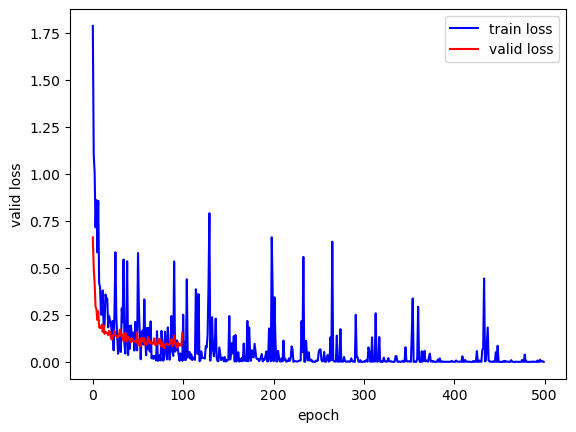

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(train_loss, 'b', label='train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.plot(valid_loss, 'r', label='valid loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(os.path.join(pic_dir,'transfomer_32_128_loss.png'))
plt.show()

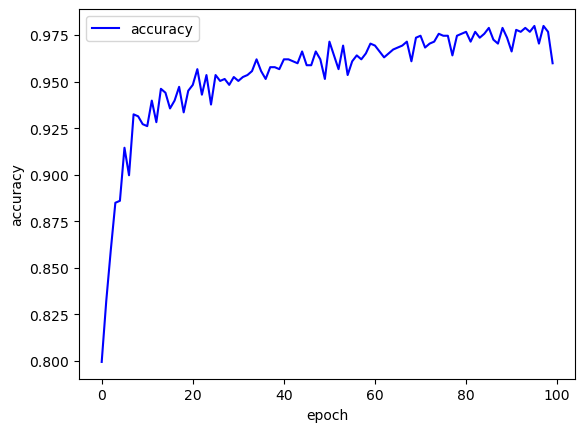

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(accuracy, 'b', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(pic_dir,'transfomer_32_128_acc.png'))
plt.show()